In [3]:
import sentinel1decoder
import pandas as pd
import numpy as np
import logging
import math
import cmath
import struct
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d



import os
import pickle
from pathlib import Path

def picklesaver(outputfile, path):
    """
    Save a Python object as a pickle file.
    """
    with open(outputfile, 'wb') as f:
        pickle.dump(path, f)


In [4]:
def focus(filename):
    inputfile = filename

    l0file = sentinel1decoder.Level0File(inputfile)
    ephemeris = l0file.ephemeris

    selected_burst = 8
    meta = l0file.get_burst_metadata(selected_burst)
    echo = l0file.get_burst_data(selected_burst)

    raw_data =  {'metadata':meta, 'ephemeris':ephemeris, 'echo':echo}
    radar_data = raw_data['echo']

    output = '/media/warmachine/DBDISK/SSFocus/data/Processed' + f'/raw_{Path(inputfile).stem}.pkl'
    # save dictionary to person_data.pkl file
    with open(output, 'wb') as fp:
        pickle.dump(raw_data, fp)
        print('dictionary saved successfully to file')
            
            
    # Plot the raw IQ data extracted from the data file
    plt.figure(figsize=(22, 22))
    plt.title("Sentinel-1 Raw I/Q Sensor Output")
    plt.imshow(abs(radar_data[:,:]), vmin=0, vmax=15, origin='lower')
    plt.xlabel("Fast Time (down range)")
    plt.ylabel("Slow Time (cross range)")
    plt.savefig('/media/warmachine/DBDISK/SSFocus/data/Processed' + f'/raw_{Path(inputfile).stem}.png')
    plt.show()


    # resize_shape = 1024
    # img_all = img_all[:20000, :20000]
    # img = np.zeros((2, resize_shape, resize_shape))
    # img[0, :, :] = resize(img_all.real, output_shape = (resize_shape, resize_shape)).astype(np.float32)
    # img[1, :, :] = resize(img_all.imag, output_shape = (resize_shape, resize_shape)).astype(np.float32)
    # img[0, :, :]  = (img[0, :, :] - img[0, :, :].mean())/img[0, :, :].std()
    # img[1, :, :]  = (img[1, :, :] - img[1, :, :].mean())/img[1, :, :].std()
    # fin = img[0,:,:] + 1j * img[1,:,:]
    # fin.dtype
    # fin.shape
    # plt.figure(figsize=(12, 12))
    # plt.title("Sentinel-1 Raw I/Q Sensor Output")
    # plt.imshow(abs(fin[:,:]), vmin=0, vmax=15, origin='lower')
    # plt.xlabel("Fast Time (down range)")
    # plt.ylabel("Slow Time (cross range)")
    # plt.show()
    # Image sizes
    len_range_line = radar_data.shape[1]
    len_az_line = radar_data.shape[0]

    # Tx pulse parameters
    c = sentinel1decoder.constants.SPEED_OF_LIGHT_MPS
    RGDEC = meta["Range Decimation"].unique()[0]
    PRI = meta["PRI"].unique()[0]
    rank = meta["Rank"].unique()[0]
    suppressed_data_time = 320/(8*sentinel1decoder.constants.F_REF)
    range_start_time = meta["SWST"].unique()[0] + suppressed_data_time
    wavelength = sentinel1decoder.constants.TX_WAVELENGTH_M

    # Sample rates
    range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
    range_sample_period = 1/range_sample_freq
    az_sample_freq = 1 / PRI
    az_sample_period = PRI

    # Fast time vector - defines the time axis along the fast time direction
    sample_num_along_range_line = np.arange(0, len_range_line, 1)
    fast_time_vec = range_start_time + (range_sample_period * sample_num_along_range_line)

    # Slant range vector - defines R0, the range of closest approach, for each range cell
    slant_range_vec = ((rank * PRI) + fast_time_vec) * c/2
        
    # Axes - defines the frequency axes in each direction after FFT
    SWL = len_range_line/range_sample_freq
    az_freq_vals = np.arange(-az_sample_freq/2, az_sample_freq/2, 1/(PRI*len_az_line))
    range_freq_vals = np.arange(-range_sample_freq/2, range_sample_freq/2, 1/SWL)
    
    # Spacecraft velocity - numerical calculation of the effective spacecraft velocity
    ecef_vels = l0file.ephemeris.apply(lambda x: math.sqrt(x["X-axis velocity ECEF"]**2 + x["Y-axis velocity ECEF"]**2 +x["Z-axis velocity ECEF"]**2), axis=1)
    velocity_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(), fill_value="extrapolate")
    x_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["X-axis position ECEF"].unique(), fill_value="extrapolate")
    y_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Y-axis position ECEF"].unique(), fill_value="extrapolate")
    z_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Z-axis position ECEF"].unique(), fill_value="extrapolate")
    space_velocities = meta.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

    x_positions = meta.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
    y_positions = meta.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
    z_positions = meta.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

    position_array = np.transpose(np.vstack((x_positions, y_positions, z_positions)))

    a = sentinel1decoder.constants.WGS84_SEMI_MAJOR_AXIS_M
    b = sentinel1decoder.constants.WGS84_SEMI_MINOR_AXIS_M
    H = np.linalg.norm(position_array, axis=1)
    W = np.divide(space_velocities, H)
    lat = np.arctan(np.divide(position_array[:, 2], position_array[:, 0]))
    local_earth_rad = np.sqrt(
        np.divide(
            (np.square(a**2 * np.cos(lat)) + np.square(b**2 * np.sin(lat))),
            (np.square(a * np.cos(lat)) + np.square(b * np.sin(lat)))
        )
    )
    cos_beta = (np.divide(np.square(local_earth_rad) + np.square(H) - np.square(slant_range_vec[:, np.newaxis]) , 2 * local_earth_rad * H))
    ground_velocities = local_earth_rad * W * cos_beta

    effective_velocities = np.sqrt(space_velocities * ground_velocities)

    D = np.sqrt(
        1 - np.divide(
            wavelength**2 * np.square(az_freq_vals),
            4 * np.square(effective_velocities)
        )
    ).T

    # We're only interested in keeping D, so free up some memory by deleting these large arrays.
    del effective_velocities
    del ground_velocities
    del cos_beta
    del local_earth_rad
    del H
    del W
    del lat
    # FFT each range line
    radar_data = np.fft.fft(radar_data, axis=1)

    # FFT each azimuth line
    radar_data = np.fft.fftshift(np.fft.fft(radar_data, axis=0), axes=0)
    # Create replica pulse
    TXPSF = meta["Tx Pulse Start Frequency"].unique()[0]
    TXPRR = meta["Tx Ramp Rate"].unique()[0]
    TXPL = meta["Tx Pulse Length"].unique()[0]
    num_tx_vals = int(TXPL*range_sample_freq)
    tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
    phi1 = TXPSF + TXPRR*TXPL/2
    phi2 = TXPRR/2
    tx_replica = np.exp(2j * np.pi * (phi1*tx_replica_time_vals + phi2*tx_replica_time_vals**2))

    # Create range filter from replica pulse
    range_filter = np.zeros(len_range_line, dtype=complex)
    index_start = np.ceil((len_range_line-num_tx_vals)/2)-1
    index_end = num_tx_vals+np.ceil((len_range_line-num_tx_vals)/2)-2
    range_filter[int(index_start):int(index_end+1)] = tx_replica
    range_filter = np.conjugate(np.fft.fft(range_filter))

    # Apply filter
    radar_data = np.multiply(radar_data, range_filter)

    del range_filter
    del tx_replica

    # Create RCMC filter
    range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)
    rcmc_shift = slant_range_vec[0] * (np.divide(1, D) - 1)
    rcmc_filter = np.exp(4j * np.pi * range_freq_vals * rcmc_shift / c)

    # Apply filter
    radar_data = np.multiply(radar_data, rcmc_filter)

    del rcmc_shift
    del rcmc_filter
    del range_freq_vals
    radar_data = np.fft.ifftshift(np.fft.ifft(radar_data, axis=1), axes=1)
    # Create filter
    az_filter = np.exp(4j * np.pi * slant_range_vec * D / wavelength)

    # Apply filter
    radar_data = np.multiply(radar_data, az_filter)

    del az_filter

    radar_data = np.fft.ifft(radar_data, axis=0)
    output2 = '/media/warmachine/DBDISK/SSFocus/data/Processed' + f'/focus_{Path(inputfile).stem}.pkl'
    with open(output, 'wb') as fp:
        pickle.dump(raw_data, fp)
        print('dictionary saved successfully to file')


    # Plot final image
    plt.figure(figsize=(40, 40))
    plt.title("Sentinel-1 Processed SAR Image")
    plt.imshow(abs(radar_data[:,:]), vmin=0, vmax=2000, origin='lower')
    # plt.imshow(abs(radar_data), origin='lower', norm=colors.LogNorm(vmin=300, vmax=10000))
    plt.xlabel("Down Range (samples)")
    plt.ylabel("Cross Range (samples)")
    plt.savefig('/media/warmachine/DBDISK/SSFocus/data/Processed' + f'/focus_{Path(inputfile).stem}.png')
    plt.show()

dictionary saved successfully to file


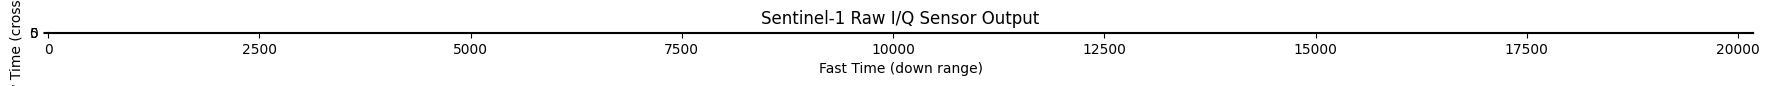

dictionary saved successfully to file


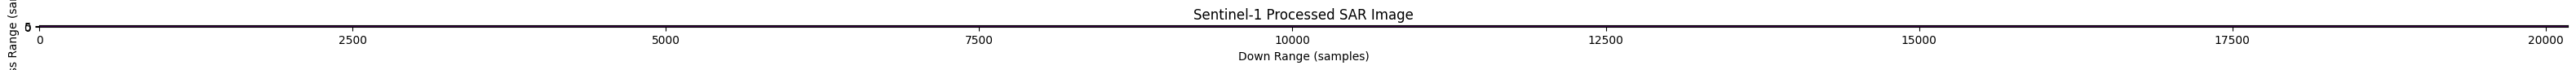

In [5]:
filename = "/media/warmachine/DBDISK/SSFocus/data/RAW/S1A_S5_RAW__0SSV_20160318T200714_20160318T200745_010428_00F76B_1563.SAFE/s1a-s5-raw-s-vv-20160318t200714-20160318t200745-010428-00f76b.dat"
 
focus(filename=filename)



In [6]:
l0file = sentinel1decoder.Level0File(filename)
l0file.packet_metadata

In [9]:
selected_burst = 1

meta = l0file.get_burst_metadata(selected_burst)
echo = l0file.get_burst_data(selected_burst)

print(echo.shape)